In [559]:
import numpy as np
import pandas as pd
import gzip
import json
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from pprint import pprint

In [560]:
pip install textblob


Note: you may need to restart the kernel to use updated packages.


In [609]:
pip show transformers


Name: transformers
Version: 4.47.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [561]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cemaydemir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [562]:
train_classification_df = pd.read_csv("train-classification.csv")
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})
train_classification_df["category"]=train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [563]:
train_classification_df.groupby(by="category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [564]:
train_data_path = "training-dataset.jsonl.gz"
username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [565]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [566]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [567]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [568]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [569]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      dtype=object)

In [570]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head()

,abdullah,abone,about,acele,acil,activities,acı,ad,ada,adam,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.050596,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.041839,0.0,0.0,0.000000,0.0,0.0
3,0.047264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.046548,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [571]:
import json
import numpy as np

# Load test data from the JSONL file
with open("test-regression-round3.jsonl", "r") as f:
    test_data = [json.loads(line) for line in f]




In [572]:
id_list=[]
for  post in test_data:
    id=post["id"]
    id_list.append(id)
len(id_list)

3000

In [573]:
len(id_list)

3000

In [574]:
test_data[100]


{'caption': 'Sanki her şey çok güneşliymişcesine…',
 'comments_count': 80,
 'id': '17967517613488331',
 'media_type': 'CAROUSEL_ALBUM',
 'media_url': 'https://scontent-sof1-2.cdninstagram.com/v/t51.29350-15/335979030_237160042106055_1042179122395521630_n.jpg?_nc_cat=110&ccb=1-7&_nc_sid=c4dd86&_nc_ohc=OrYNzlpYvdMAX8iC19B&_nc_ht=scontent-sof1-2.cdninstagram.com&edm=AL-3X8kEAAAA&oh=00_AfAR8ku13dGBqtNdr6Z83DT_TOfpYgO9VW40h65Jiqob_g&oe=65626568',
 'timestamp': '2023-03-15 20:16:40',
 'username': 'denizzbolisik'}

In [575]:
test_data[0]

{'caption': 'Ayvalık Belediyesi Kasım Ayı Olağan Meclis Toplantısı’nı Vural Sineması Nejat Uygur Sahnesi’nde gerçekleştirdik.\n\nAlınan kararların Ayvalık’ımıza hayırlı olmasını dilerim.',
 'comments_count': 10,
 'id': '18299464882193238',
 'media_type': 'CAROUSEL_ALBUM',
 'media_url': 'https://scontent-sof1-2.cdninstagram.com/v/t51.29350-15/398502640_367498438952512_6710374471736346193_n.jpg?_nc_cat=107&ccb=1-7&_nc_sid=c4dd86&_nc_ohc=QFdBTP4J-X8AX8jZhY4&_nc_ht=scontent-sof1-2.cdninstagram.com&edm=AL-3X8kEAAAA&oh=00_AfDe8viPR0XWIPWwP_ravKlJ1b7kqr_pxMs0DT7IIf6DIQ&oe=65585C5E',
 'timestamp': '2023-11-01 12:43:50',
 'username': 'mesuterginofficial'}

In [614]:
df=pd.DataFrame(test_data,columns=list(test_data[0].keys()),index=[np.arange(3000)])
    

In [615]:
df

,caption,comments_count,id,media_type,media_url,timestamp,username
0,Ayvalık Belediyesi Kasım Ayı Olağan Meclis Top...,10,18299464882193238,CAROUSEL_ALBUM,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-11-01 12:43:50,mesuterginofficial
1,Olumsuz hava şartları sonucu ilçemizde ki sahi...,19,17870639199008459,VIDEO,None,2023-11-20 11:17:14,daricabelediyesi
2,"❝Bizler ki aynı kitaba baş eğmiş insanlarız, b...",22,17976060503438195,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...,2023-11-13 13:02:57,fikriyat
3,❤️,249,17980348256173250,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...,2023-07-31 10:31:17,obenalkan
4,"Değerlerimizin ışığında, dünyamıza iyi bakmak,...",0,18030944311530609,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2023-07-13 13:36:38,kaledehayat
...,...,...,...,...,...,...,...
2995,İsfanbul AVM için yaptığımız etkinlik çekimi!📽...,1,17858405624192341,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2020-10-02 14:48:04,tekincreativemedia
2996,"For a holiday in nature, in touch with nature....",14,18011151136959471,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t39...,2023-10-24 10:12:05,tuimagiclifebelek
2997,İstanbul seyahatinizde mutlaka deneyimlemeniz ...,0,18368462524073706,CAROUSEL_ALBUM,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-11-20 08:59:17,dedemanistanbul
2998,Ürün detaylarımız ve fiyat bilgileri için DM D...,2,17933092634762150,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...,2023-10-20 15:35:16,lussomobilya


In [616]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [617]:
def highlight_reel_count(name_list):
    list_of_follow=[]
    for name in name_list:
        if name in list(username2profile_test.keys()):
          num_of_follow=username2profile_test[name].get("highlight_reel_count")
          list_of_follow.append(num_of_follow)
        else:
          num_of_follow=username2profile_train[name].get("highlight_reel_count")
          list_of_follow.append(num_of_follow)
    return list_of_follow

In [618]:
def check_type(list_):
    list_element=[]
    for element in list_:
        if  type(element)==int:
            list_element.append(element)
    return list_element

In [619]:
def find_last_likes(name_list):
    list_averages=[]
    for name in name_list:
        list_=[]
        if name in list(username2posts_train.keys()):
            for post in username2posts_train[name]:
                like=post.get("like_count")
                list_.append(like)
        if name in list(username2posts_test.keys()):
           for post in username2posts_test[name]:
                like=post.get("like_count")
                if type(like)==None:
                    list.append(0)
                    like=0
                else:
                    list_.append(like)
        average=0
        list_=check_type(list_)
        if len(list_)!=0:
            sum_=[]
            if len(list_)>=11:
              sum_=list_[0:10]
              average=sum(list_)
            else:
              average=0
        list_averages.append(average)
    
    return list_averages
    

In [620]:
def find_last_like(name_list):
    list_averages=[]
    for name in name_list:
        list_=[]
        if name in list(username2posts_train.keys()):
            for post in username2posts_train[name]:
                like=post.get("like_count")
                list_.append(like)
        if name in list(username2posts_test.keys()):
           for post in username2posts_test[name]:
                like=post.get("like_count")
                if type(like)==None:
                    list.append(0)
                    like=0
                else:
                    list_.append(like)
        average=0
        list_=check_type(list_)
        if len(list_)!=0:
            sum_=list_[0]
            average=sum_
        list_averages.append(average)
    
    return list_averages
    

In [621]:
def find_average_like(name_list):
    list_averages=[]
    for name in name_list:
        list_=[]
        if name in list(username2posts_train.keys()):
            for post in username2posts_train[name]:
                like=post.get("like_count")
                list_.append(like)
        if name in list(username2posts_test.keys()):
           for post in username2posts_test[name]:
                like=post.get("like_count")
                if type(like)==None:
                    list.append(0)
                    like=0
                else:
                    list_.append(like)
        average=0
        list_=check_type(list_)
        if len(list_)!=0:
            sum_=sum(list_)
            average=sum_/len(list_)
        list_averages.append(average)
    
    return list_averages
    
    
    

In [622]:
import numpy as np

def find_trend(name_list, window_size=20):
    """
    Calculate the slope of the trend for the last `window_size` likes for each user.

    Args:
        name_list (list): List of usernames.
        window_size (int): Number of most recent likes to consider for trend calculation.

    Returns:
        list: Slopes of the linear trend for the last `window_size` likes for each user.
    """
    list_trends = []  # To store linear trend slopes for each user

    for name in name_list:
        likes_list = []

        # Collect likes from training data
        if name in username2posts_train:
            for post in username2posts_train[name]:
                like = post.get("like_count")
                likes_list.append(like)

        # Collect likes from test data
        if name in username2posts_test:
            for post in username2posts_test[name]:
                like = post.get("like_count")
                if like is None:  # Handle None type
                    like = 0
                likes_list.append(like)

        # Ensure all values are valid numeric types
        likes_list = [like for like in likes_list if isinstance(like, (int, float))]

        # Consider only the last `window_size` likes
        recent_likes = likes_list[-window_size:]

        # Compute the linear trend slope using numpy.polyfit
        if len(recent_likes) > 1:  # A trend requires at least 2 points
            x = np.arange(len(recent_likes))  # Time indices (0, 1, 2, ...)
            y = np.array(recent_likes)
            slope, _ = np.polyfit(x, y, 1)  # Linear fit: slope and intercept
        else:
            slope = 0  # No trend if less than two like counts are available

        # Append the result
        list_trends.append(slope)

    return list_trends


In [623]:
def find_weighted_average_like(name_list):
    list_weighted_averages = []

    for name in name_list:
        likes_list = []

        # Collect likes from training data
        if name in username2posts_train.keys():
            for post in username2posts_train[name]:
                likes_list.append(post.get("like_count", 0))

        # Collect likes from test data
        if name in username2posts_test.keys():
            for post in username2posts_test[name]:
                likes_list.append(post.get("like_count", 0))

        # Ensure the list is clean and contains only numeric values
        likes_list = check_type(likes_list)

        if len(likes_list) == 0:
            list_weighted_averages.append(0)  # Default to 0 if no likes are available
            continue

        # Assign weights such that the last value has the highest weight
        weights = [i + 1 for i in range(len(likes_list))]
        total_weight = sum(weights)

        # Calculate the weighted average
        weighted_sum = sum(like * weight for like, weight in zip(likes_list, weights))
        weighted_average = weighted_sum / total_weight

        list_weighted_averages.append(weighted_average)

    return list_weighted_averages


In [624]:
def find_maximum_like(name_list):
    list_max_likes = []
    for name in name_list:
        list_ = []
        if name in username2posts_train.keys():
            for post in username2posts_train[name]:
                like = post.get("like_count")
                list_.append(like)
        if name in username2posts_test.keys():
            for post in username2posts_test[name]:
                like = post.get("like_count")
                list_.append(like or 0)  # Handle None values

        list_ = check_type(list_)
        if len(list_) > 0:
            max_like = max(list_)  
        else:
            max_like = 0
        list_max_likes.append(max_like)

    return list_max_likes


In [625]:
def find_minimum_like(name_list):
    list_max_likes=[]
    for name in name_list:
        list_=[]
        if name in list(username2posts_train.keys()):
            for post in username2posts_train[name]:
                like=post.get("like_count")
                list_.append(like)
        if name in list(username2posts_test.keys()):
           for post in username2posts_test[name]:
                like=post.get("like_count")
                if type(like)==None:
                    list.append(0)
                    like=0
                else:
                    list_.append(like)
        list_=check_type(list_)
        if len(list_)!=0:
          max_like=min(list_)
        else:
            max_like=0
        list_max_likes.append(max_like)
    
    return list_max_likes
    
    
    

In [626]:
def get_num_followers(name_list):
    list_of_follow=[]
    for name in name_list:
        if name in list(username2profile_test.keys()):
          num_of_follow=username2profile_test[name].get("follower_count")
          list_of_follow.append(num_of_follow)
        else:
          num_of_follow=username2profile_train[name].get("follower_count")
          list_of_follow.append(num_of_follow)
    return list_of_follow

In [627]:
def get_num_followings(name_list):
    list_of_follow=[]
    for name in name_list:
        if name in list(username2profile_test.keys()):
          num_of_follow=username2profile_test[name].get("following_count")
          list_of_follow.append(num_of_follow)
        else:
          num_of_follow=username2profile_train[name].get("following_count")
          list_of_follow.append(num_of_follow)
    return list_of_follow

In [628]:
def find_private(name_list):
    list_of_follow=[]
    for name in name_list:
        if name in list(username2profile_test.keys()):
          num_of_follow=username2profile_test[name].get("is_private")
          list_of_follow.append(num_of_follow)
        else:
          num_of_follow=username2profile_train[name].get("is_private")
          list_of_follow.append(num_of_follow)
    return list_of_follow

In [629]:
def find_verified(name_list):
    list_of_follow=[]
    for name in name_list:
        if name in list(username2profile_test.keys()):
          num_of_follow=username2profile_test[name].get('is_verified')
          list_of_follow.append(num_of_follow)
        else:
          num_of_follow=username2profile_train[name].get('is_verified')
          list_of_follow.append(num_of_follow)
    return list_of_follow

In [630]:
def find_average_comment(name_list):
    list_averages=[]
    for name in name_list:
        list_=[]
        if name in list(username2posts_train.keys()):
            for post in username2posts_train[name]:
                like=post.get("comments_count")
                list_.append(like)
        if name in list(username2posts_test.keys()):
           for post in username2posts_test[name]:
                like=post.get("comments_count")
                if type(like)==None:
                    list.append(0)
                    like=0
                else:
                    list_.append(like)
        average=0
        list_=check_type(list_)
        if len(list_)!=0:
            sum_=sum(list_)
            average=sum_/len(list_)
        list_averages.append(average)
    
    return list_averages
    
    
    

In [631]:
def find_caption_length(caption_series):
    """
    Returns the length of each caption (number of characters).
    """
    lengths = []
    for cap in caption_series:
        cap_str = str(cap) if cap else ""
        lengths.append(len(cap_str))
    return lengths

def find_hashtag_count(caption_series):
    """
    Returns the number of '#' in each caption.
    """
    counts = []
    for cap in caption_series:
        cap_str = str(cap) if cap else ""
        counts.append(cap_str.count("#"))
    return counts

def find_mention_count(caption_series):
    """
    Returns the number of '@' in each caption.
    """
    counts = []
    for cap in caption_series:
        cap_str = str(cap) if cap else ""
        counts.append(cap_str.count("@"))
    return counts


In [632]:
def find_average_like_excluding_current(df, user_col="username", like_col="like_count"):
    """
    Adds a column 'average_like_excl' to df, where each row is the
    average like_count of that row's user *excluding* the current post.
    """
    # We define an inner function that, for each user's subset (group),
    # calculates the average excluding the current post.
    def _compute_excl_avg(group):
        total_likes = group[like_col].sum()
        count_posts = len(group)
        # For each row, subtract that row's like, and divide by count-1
        group["average_like_excl"] = group[like_col].apply(
            lambda x: (total_likes - x) / (count_posts - 1) if count_posts > 1 else 0
        )
        return group

    df = df.copy()  # so we don't overwrite original
    df = df.groupby(user_col, group_keys=False).apply(_compute_excl_avg)
    return df

def find_maximum_like_excluding_current(df, user_col="username", like_col="like_count"):
    """
    Adds a column 'max_like_excl' to df, where each row is the
    max like_count of that row's user *excluding* the current post.
    """
    def _compute_excl_max(group):
        all_likes = group[like_col].tolist()
        overall_max = max(all_likes) if len(all_likes) > 0 else 0
        
        def exclude_self(row_like):
            # if there's only 1 post, excluding it => 0
            if len(all_likes) == 1:
                return 0
            # if the current post's like == overall max
            # and that max occurs exactly once, find the "2nd max"
            if row_like == overall_max and all_likes.count(overall_max) == 1:
                # remove that single max from the list
                likes_excluding_self = [lk for lk in all_likes if lk != row_like]
                return max(likes_excluding_self) if likes_excluding_self else 0
            else:
                # otherwise, overall_max is still valid
                return overall_max
        
        group["max_like_excl"] = group[like_col].apply(exclude_self)
        return group

    df = df.copy()
    df = df.groupby(user_col, group_keys=False).apply(_compute_excl_max)
    return df

def find_minimum_like_excluding_current(df, user_col="username", like_col="like_count"):
    """
    Adds a column 'min_like_excl' to df, where each row is the
    min like_count of that row's user *excluding* the current post.
    """
    def _compute_excl_min(group):
        all_likes = group[like_col].tolist()
        overall_min = min(all_likes) if len(all_likes) > 0 else 0
        
        def exclude_self(row_like):
            if len(all_likes) == 1:
                return 0
            if row_like == overall_min and all_likes.count(overall_min) == 1:
                likes_excluding_self = [lk for lk in all_likes if lk != row_like]
                return min(likes_excluding_self) if likes_excluding_self else 0
            else:
                return overall_min
        
        group["min_like_excl"] = group[like_col].apply(exclude_self)
        return group

    df = df.copy()
    df = df.groupby(user_col, group_keys=False).apply(_compute_excl_min)
    return df


In [633]:
df["num_followers"] = get_num_followers(df["username"])
# df_full["is_private"] = find_private(df_full["username"])  
#df_full["is_verified"] = find_verified(df_full["username"])  
df["average_like_excl"] = find_average_like(df["username"])
df["max_like_excl"] = find_maximum_like(df["username"])  # Uses built-in max
df["highlight_reel_count"] = highlight_reel_count(df["username"])
df["min_like_excl"] = find_minimum_like(df["username"])
df["caption_length"] = find_caption_length(df["caption"])
df["hashtag_count"] = find_hashtag_count(df["caption"])
df["mention_count"] = find_mention_count(df["caption"])
#df["weighted_average_like"] = find_weighted_average_like(df["username"])
df["average_comment"]=find_average_comment(df["username"])
df["difference_comment"]=df["average_comment"]-df["comments_count"]
df["last_like"]=find_last_like(df["username"])
df["average_minus_last"]=df["average_like_excl"]-df["last_like"]
df["last_likes"]=find_last_likes(df["username"])
df["average_minus_last_likes"]=df["average_like_excl"]-df["last_likes"]
df["trend"]=find_trend(df["username"])

In [634]:
df

,caption,comments_count,id,media_type,media_url,timestamp,username,num_followers,average_like_excl,max_like_excl,...,caption_length,hashtag_count,mention_count,average_comment,difference_comment,last_like,average_minus_last,last_likes,average_minus_last_likes,trend
0,Ayvalık Belediyesi Kasım Ayı Olağan Meclis Top...,10,18299464882193238,CAROUSEL_ALBUM,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-11-01 12:43:50,mesuterginofficial,19690,1054.571429,4590,...,171,0,0,22.171429,12.171429,346,708.571429,36910,-3.585543e+04,57.180451
1,Olumsuz hava şartları sonucu ilçemizde ki sahi...,19,17870639199008459,VIDEO,None,2023-11-20 11:17:14,daricabelediyesi,37899,197.857143,597,...,139,1,0,7.171429,-11.828571,372,-174.142857,6925,-6.727143e+03,-0.743609
2,"❝Bizler ki aynı kitaba baş eğmiş insanlarız, b...",22,17976060503438195,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...,2023-11-13 13:02:57,fikriyat,513176,7059.971429,35349,...,87,0,0,33.114286,11.114286,1210,5849.971429,247099,-2.400390e+05,371.376692
3,❤️,249,17980348256173250,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...,2023-07-31 10:31:17,obenalkan,277443,36167.714286,119415,...,2,0,0,242.371429,-6.628571,21761,14406.714286,1265870,-1.229702e+06,594.409774
4,"Değerlerimizin ışığında, dünyamıza iyi bakmak,...",0,18030944311530609,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2023-07-13 13:36:38,kaledehayat,5839,95.085714,346,...,443,2,0,0.714286,0.714286,65,30.085714,3328,-3.232914e+03,-0.947368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,İsfanbul AVM için yaptığımız etkinlik çekimi!📽...,1,17858405624192341,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2020-10-02 14:48:04,tekincreativemedia,290,14.240000,28,...,277,8,0,0.160000,-0.840000,7,7.240000,356,-3.417600e+02,0.844361
2996,"For a holiday in nature, in touch with nature....",14,18011151136959471,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t39...,2023-10-24 10:12:05,tuimagiclifebelek,14928,196.857143,793,...,359,20,0,3.742857,-10.257143,210,-13.142857,6890,-6.693143e+03,0.212782
2997,İstanbul seyahatinizde mutlaka deneyimlemeniz ...,0,18368462524073706,CAROUSEL_ALBUM,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-11-20 08:59:17,dedemanistanbul,4112,28.571429,192,...,513,11,0,71.114286,71.114286,42,-13.428571,1000,-9.714286e+02,2.616541
2998,Ürün detaylarımız ve fiyat bilgileri için DM D...,2,17933092634762150,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...,2023-10-20 15:35:16,lussomobilya,17154,31.114286,52,...,319,12,0,0.342857,-1.657143,14,17.114286,1089,-1.057886e+03,0.190226


In [635]:
df_last=df

STARTING TO PROCESS TRAINING DATA

In [636]:
full_dataset=[]
for name in username2posts_train:
    for post in username2posts_train[name]:
        post["username"]=name
        full_dataset.append(post)
for name in username2posts_test:
    for post in username2posts_test[name]:
        post["username"]=name
        full_dataset.append(post)

In [637]:
df_full=pd.DataFrame(full_dataset,columns=full_dataset[0].keys(),index=np.arange(len(full_dataset)))

In [638]:
df_full

,caption,comments_count,id,like_count,media_type,media_url,timestamp,username
0,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,0,17990918969458720,6.0,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-10-29 09:12:30,deparmedya
1,Oriflame Duologi Lansmanı #isveçtengelengüzell...,1,18219250732221045,22.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-08 19:11:13,deparmedya
2,#oriflameilesaçbakımdevrimi ✌️,0,18311380465102328,19.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:40:54,deparmedya
3,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,1,18089518138361507,19.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:27:48,deparmedya
4,07 Agustos’23 #oriflameturkiye #duoloji,0,18012743929758497,21.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:12:06,deparmedya
...,...,...,...,...,...,...,...,...
187297,Alışılmışın Dışına Çık!\n\n📍İşçi Blokları mh. ...,1,17970896356402818,34.0,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-06-07 07:49:51,tetrancaffeine
187298,Bayramınız Kutlu olsun🥳🤩,0,17930502130524900,36.0,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t51...,2021-05-13 12:21:14,tetrancaffeine
187299,Ben Bir Kahve Aşığıyım!\n\nİddialı Kahvelerin ...,2,17889308990150405,79.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-08 16:02:10,tetrancaffeine
187300,"Sonuçlar 332plus sayfasından,11.05.2021 tarihi...",380,17869632995380257,199.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-07 15:31:15,tetrancaffeine


In [639]:
df_full["num_followers"] = get_num_followers(df_full["username"])
# df_full["is_private"] = find_private(df_full["username"])  # Uncomment if function exists
#df_full["is_verified"] = find_verified(df_full["username"])  # Uncomment if function exists
#df_full["average_like_excl"] = find_average_like(df_full["username"])
# df_full["maximum_like"] = find_maximum_like(df_full["username"])  # Uses built-in max
df_full["highlight_reel_count"] = highlight_reel_count(df_full["username"])
# df_full["minimum_like"] = find_minimum_like(df_full["username"])
#df_full["weighted_average_like"] = find_weighted_average_like(df_full["username"])
df_full["caption_length"] = find_caption_length(df_full["caption"])
df_full["hashtag_count"] = find_hashtag_count(df_full["caption"])
df_full["mention_count"] = find_mention_count(df_full["caption"])
df_full = find_average_like_excluding_current(df_full)
df_full = find_maximum_like_excluding_current(df_full)
df_full = find_minimum_like_excluding_current(df_full)
df_full["average_comment"]=find_average_comment(df_full["username"])
df_full["difference_comment"]=df_full["average_comment"]-df_full["comments_count"]
df_full["last_like"]=find_last_like(df_full["username"])
df_full["average_minus_last"]=df_full["average_like_excl"]-df_full["last_like"]
df_full["last_likes"]=find_last_likes(df_full["username"])
df_full["average_minus_last_likes"]=df_full["average_like_excl"]-df_full["last_likes"]
df_full["trend"]=find_trend(df_full["username"])

/var/folders/1s/210spld15vg5k_xs0p_62bt80000gn/T/ipykernel_26672/1118988491.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(user_col, group_keys=False).apply(_compute_excl_avg)
/var/folders/1s/210spld15vg5k_xs0p_62bt80000gn/T/ipykernel_26672/1118988491.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(user_col, group_keys=False).apply(_compute_excl_max)
/var/folders/1

In [640]:
df_full=df_full.dropna()


In [641]:
df_full

,caption,comments_count,id,like_count,media_type,media_url,timestamp,username,num_followers,highlight_reel_count,...,average_like_excl,max_like_excl,min_like_excl,average_comment,difference_comment,last_like,average_minus_last,last_likes,average_minus_last_likes,trend
0,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,0,17990918969458720,6.0,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-10-29 09:12:30,deparmedya,1167,6,...,11.705882,26.0,4.0,0.342857,0.342857,6,5.705882,404,-392.294118,0.474436
1,Oriflame Duologi Lansmanı #isveçtengelengüzell...,1,18219250732221045,22.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-08 19:11:13,deparmedya,1167,6,...,11.235294,26.0,4.0,0.342857,-0.657143,6,5.235294,404,-392.764706,0.474436
2,#oriflameilesaçbakımdevrimi ✌️,0,18311380465102328,19.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:40:54,deparmedya,1167,6,...,11.323529,26.0,4.0,0.342857,0.342857,6,5.323529,404,-392.676471,0.474436
3,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,1,18089518138361507,19.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:27:48,deparmedya,1167,6,...,11.323529,26.0,4.0,0.342857,-0.657143,6,5.323529,404,-392.676471,0.474436
4,07 Agustos’23 #oriflameturkiye #duoloji,0,18012743929758497,21.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:12:06,deparmedya,1167,6,...,11.264706,26.0,4.0,0.342857,0.342857,6,5.264706,404,-392.735294,0.474436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187297,Alışılmışın Dışına Çık!\n\n📍İşçi Blokları mh. ...,1,17970896356402818,34.0,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-06-07 07:49:51,tetrancaffeine,1672,4,...,38.558824,199.0,18.0,11.200000,10.200000,25,13.558824,1345,-1306.441176,2.566165
187298,Bayramınız Kutlu olsun🥳🤩,0,17930502130524900,36.0,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t51...,2021-05-13 12:21:14,tetrancaffeine,1672,4,...,38.500000,199.0,18.0,11.200000,11.200000,25,13.500000,1345,-1306.500000,2.566165
187299,Ben Bir Kahve Aşığıyım!\n\nİddialı Kahvelerin ...,2,17889308990150405,79.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-08 16:02:10,tetrancaffeine,1672,4,...,37.235294,199.0,18.0,11.200000,9.200000,25,12.235294,1345,-1307.764706,2.566165
187300,"Sonuçlar 332plus sayfasından,11.05.2021 tarihi...",380,17869632995380257,199.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-07 15:31:15,tetrancaffeine,1672,4,...,33.705882,79.0,18.0,11.200000,-368.800000,25,8.705882,1345,-1311.294118,2.566165


CLEANİNG DF_FULL

In [642]:
def encode_media_type(df):
    """
    One-hot encodes the 'media_type' column.
    Returns a new DataFrame with additional columns and drops the original.
    """
    return pd.get_dummies(df, columns=["media_type"], prefix="media_type")

In [643]:
df_full = encode_media_type(df_full)
df=encode_media_type(df)
df_full

,caption,comments_count,id,like_count,media_url,timestamp,username,num_followers,highlight_reel_count,caption_length,...,average_comment,difference_comment,last_like,average_minus_last,last_likes,average_minus_last_likes,trend,media_type_CAROUSEL_ALBUM,media_type_IMAGE,media_type_VIDEO
0,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,0,17990918969458720,6.0,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-10-29 09:12:30,deparmedya,1167,6,41,...,0.342857,0.342857,6,5.705882,404,-392.294118,0.474436,False,True,False
1,Oriflame Duologi Lansmanı #isveçtengelengüzell...,1,18219250732221045,22.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-08 19:11:13,deparmedya,1167,6,76,...,0.342857,-0.657143,6,5.235294,404,-392.764706,0.474436,False,False,True
2,#oriflameilesaçbakımdevrimi ✌️,0,18311380465102328,19.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:40:54,deparmedya,1167,6,30,...,0.342857,0.342857,6,5.323529,404,-392.676471,0.474436,False,False,True
3,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,1,18089518138361507,19.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:27:48,deparmedya,1167,6,58,...,0.342857,-0.657143,6,5.323529,404,-392.676471,0.474436,False,False,True
4,07 Agustos’23 #oriflameturkiye #duoloji,0,18012743929758497,21.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:12:06,deparmedya,1167,6,39,...,0.342857,0.342857,6,5.264706,404,-392.735294,0.474436,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187297,Alışılmışın Dışına Çık!\n\n📍İşçi Blokları mh. ...,1,17970896356402818,34.0,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-06-07 07:49:51,tetrancaffeine,1672,4,460,...,11.200000,10.200000,25,13.558824,1345,-1306.441176,2.566165,True,False,False
187298,Bayramınız Kutlu olsun🥳🤩,0,17930502130524900,36.0,https://scontent-sof1-2.cdninstagram.com/v/t51...,2021-05-13 12:21:14,tetrancaffeine,1672,4,24,...,11.200000,11.200000,25,13.500000,1345,-1306.500000,2.566165,False,True,False
187299,Ben Bir Kahve Aşığıyım!\n\nİddialı Kahvelerin ...,2,17889308990150405,79.0,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-08 16:02:10,tetrancaffeine,1672,4,576,...,11.200000,9.200000,25,12.235294,1345,-1307.764706,2.566165,False,True,False
187300,"Sonuçlar 332plus sayfasından,11.05.2021 tarihi...",380,17869632995380257,199.0,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-07 15:31:15,tetrancaffeine,1672,4,69,...,11.200000,-368.800000,25,8.705882,1345,-1311.294118,2.566165,False,True,False


In [644]:
def extract_time_features(df, time_col="timestamp"):
    """
    Converts time_col to datetime, then extracts
    'year', 'month', 'day_of_week', and 'hour'.
    Appends them to the DataFrame.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    df["year"] = df[time_col].dt.year
    df["month"] = df[time_col].dt.month
    df["day_of_week"] = df[time_col].dt.dayofweek
    df["hour"] = df[time_col].dt.hour

    return df


In [645]:
df_full = extract_time_features(df_full, time_col="timestamp")
df=extract_time_features(df, time_col="timestamp")
df_full


,caption,comments_count,id,like_count,media_url,timestamp,username,num_followers,highlight_reel_count,caption_length,...,last_likes,average_minus_last_likes,trend,media_type_CAROUSEL_ALBUM,media_type_IMAGE,media_type_VIDEO,year,month,day_of_week,hour
0,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,0,17990918969458720,6.0,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-10-29 09:12:30,deparmedya,1167,6,41,...,404,-392.294118,0.474436,False,True,False,2023,10,6,9
1,Oriflame Duologi Lansmanı #isveçtengelengüzell...,1,18219250732221045,22.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-08 19:11:13,deparmedya,1167,6,76,...,404,-392.764706,0.474436,False,False,True,2023,8,1,19
2,#oriflameilesaçbakımdevrimi ✌️,0,18311380465102328,19.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:40:54,deparmedya,1167,6,30,...,404,-392.676471,0.474436,False,False,True,2023,8,0,21
3,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,1,18089518138361507,19.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:27:48,deparmedya,1167,6,58,...,404,-392.676471,0.474436,False,False,True,2023,8,0,21
4,07 Agustos’23 #oriflameturkiye #duoloji,0,18012743929758497,21.0,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-07 21:12:06,deparmedya,1167,6,39,...,404,-392.735294,0.474436,False,False,True,2023,8,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187297,Alışılmışın Dışına Çık!\n\n📍İşçi Blokları mh. ...,1,17970896356402818,34.0,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-06-07 07:49:51,tetrancaffeine,1672,4,460,...,1345,-1306.441176,2.566165,True,False,False,2021,6,0,7
187298,Bayramınız Kutlu olsun🥳🤩,0,17930502130524900,36.0,https://scontent-sof1-2.cdninstagram.com/v/t51...,2021-05-13 12:21:14,tetrancaffeine,1672,4,24,...,1345,-1306.500000,2.566165,False,True,False,2021,5,3,12
187299,Ben Bir Kahve Aşığıyım!\n\nİddialı Kahvelerin ...,2,17889308990150405,79.0,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-08 16:02:10,tetrancaffeine,1672,4,576,...,1345,-1307.764706,2.566165,False,True,False,2021,5,5,16
187300,"Sonuçlar 332plus sayfasından,11.05.2021 tarihi...",380,17869632995380257,199.0,https://scontent-sof1-1.cdninstagram.com/v/t51...,2021-05-07 15:31:15,tetrancaffeine,1672,4,69,...,1345,-1311.294118,2.566165,False,True,False,2021,5,4,15


In [647]:
from transformers import pipeline

# Initialize Hugging Face sentiment analysis pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=0  # Set to -1 for CPU or 0 for GPU if available
)

def bert_sentiment_score(text):
    """
    Calculate a numerical sentiment score using BERT, ensuring input length is within limits.
    """
    if pd.notnull(text):
        # Truncate text to ensure it doesn't exceed the model's token limit
        encoded = sentiment_analyzer.tokenizer(
            text,
            max_length=512,
            truncation=True,
            return_tensors="pt"
        )
        truncated_text = sentiment_analyzer.tokenizer.decode(encoded["input_ids"][0], skip_special_tokens=True)
        
        # Perform sentiment analysis
        result = sentiment_analyzer(truncated_text)
        return float(result[0]['score'])
    return 0

# Apply Sentiment Analysis to the Caption Column
df_full["sentiment_score"] = df_full["caption"].apply(
    lambda x: bert_sentiment_score(x) if pd.notnull(x) else 0  # Default to 0 for missing captions
)
df["sentiment_score"] = df["caption"].apply(
    lambda x: bert_sentiment_score(x) if pd.notnull(x) else 0  # Default to 0 for missing captions
)


print(df_full.head())


Device set to use mps:0


                                             caption  comments_count  \
0          Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷               0   
1  Oriflame Duologi Lansmanı #isveçtengelengüzell...               1   
2                     #oriflameilesaçbakımdevrimi ✌️               0   
3  ✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...               1   
4            07 Agustos’23 #oriflameturkiye #duoloji               0   

                  id  like_count  \
0  17990918969458720         6.0   
1  18219250732221045        22.0   
2  18311380465102328        19.0   
3  18089518138361507        19.0   
4  18012743929758497        21.0   

                                           media_url           timestamp  \
0  https://scontent-sof1-2.cdninstagram.com/v/t51... 2023-10-29 09:12:30   
1  https://scontent-sof1-2.cdninstagram.com/o1/v/... 2023-08-08 19:11:13   
2  https://scontent-sof1-2.cdninstagram.com/o1/v/... 2023-08-07 21:40:54   
3  https://scontent-sof1-2.cdninstagram.com/o1

In [648]:
#df_full = df_full[df_full["maximum_like"] != 0].reset_index(drop=True)
df_full=df_full.drop(columns=["caption","id", "media_url","username","timestamp"]) #,"media_type", 
df=df.drop(columns=["caption","id", "media_url","username","timestamp"])
# df_test=df.drop(columns=["caption","id","media_type","media_url","username","timestamp"])


In [676]:
y=df_full["like_count"]

In [677]:
X=df_full.drop(columns="like_count")

In [678]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [679]:
df=df[X_train.columns]
df_test=df

In [680]:
original_train=X_train.copy()
original_y_train=y_train.copy()

In [669]:
df.columns

Index(['comments_count', 'num_followers', 'highlight_reel_count',
       'caption_length', 'hashtag_count', 'mention_count', 'average_like_excl',
       'max_like_excl', 'min_like_excl', 'average_comment',
       'difference_comment', 'last_like', 'average_minus_last', 'last_likes',
       'average_minus_last_likes', 'trend', 'media_type_CAROUSEL_ALBUM',
       'media_type_IMAGE', 'media_type_VIDEO', 'year', 'month', 'day_of_week',
       'hour', 'sentiment_score'],
      dtype='object')

In [ ]:
original_train.columns

Optimal number of clusters (BIC): 50

=== Training for Cluster 0 ===

=== Training for Cluster 1 ===

=== Training for Cluster 2 ===

=== Training for Cluster 3 ===

=== Training for Cluster 4 ===

=== Training for Cluster 5 ===

=== Training for Cluster 6 ===

=== Training for Cluster 7 ===

=== Training for Cluster 8 ===

=== Training for Cluster 9 ===

=== Training for Cluster 10 ===

=== Training for Cluster 11 ===

=== Training for Cluster 12 ===

=== Training for Cluster 13 ===

=== Training for Cluster 14 ===

=== Training for Cluster 15 ===

=== Training for Cluster 16 ===

=== Training for Cluster 17 ===

=== Training for Cluster 18 ===

=== Training for Cluster 19 ===

=== Training for Cluster 20 ===

=== Training for Cluster 21 ===

=== Training for Cluster 22 ===

=== Training for Cluster 23 ===

=== Training for Cluster 24 ===

=== Training for Cluster 25 ===

=== Training for Cluster 26 ===

=== Training for Cluster 27 ===

=== Training for Cluster 28 ===

=== Training fo

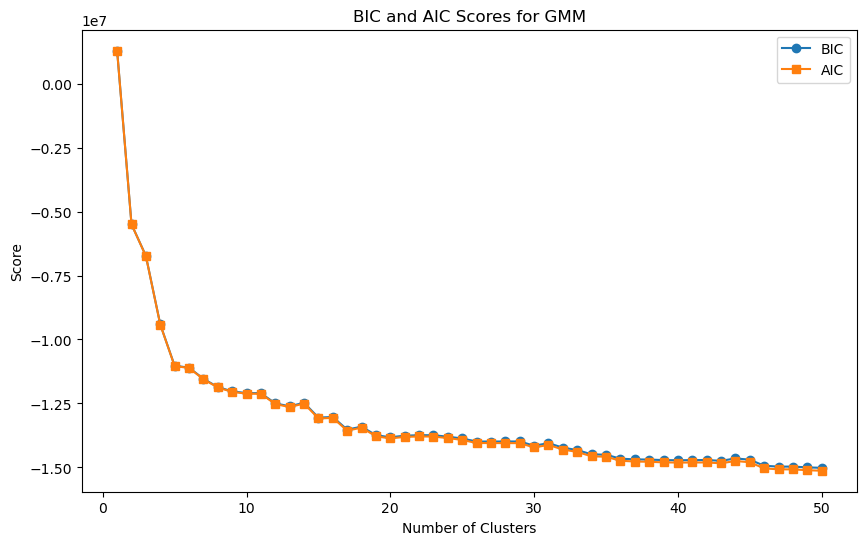

In [402]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Custom Log MSE function
def log_mse(y_true, y_pred):
    return mean_squared_error(np.log1p(y_true), np.log1p(y_pred))

# Step 1: Preprocess Features
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)

# Step 2: Find Optimal Number of Clusters
def find_optimal_clusters(X, max_clusters=50):
    bic_scores = []
    aic_scores = []
    for n in range(1, max_clusters + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
    return bic_scores, aic_scores

bic_scores, aic_scores = find_optimal_clusters(X_train_scaled, max_clusters=50)

# Determine the optimal number of clusters based on the minimum BIC score
optimal_n_clusters = np.argmin(bic_scores) + 1
print(f"Optimal number of clusters (BIC): {optimal_n_clusters}")

# Step 3: Fit GMM with Optimal Clusters
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
train_clusters = gmm.fit_predict(X_train_scaled)
test_clusters = gmm.predict(X_test_scaled)

# Step 4: Train Models for Each Cluster
cluster_models = {}

for cluster in range(optimal_n_clusters):
    print(f"\n=== Training for Cluster {cluster} ===")

    # Filter data by cluster
    cluster_mask_train = (train_clusters == cluster)
    X_train_cluster = X_train_scaled[cluster_mask_train]
    y_train_cluster = y_train[cluster_mask_train]

    if len(X_train_cluster) == 0:
        print(f"Cluster {cluster} has no training samples. Skipping...")
        continue

    # Train GradientBoostingRegressor
    model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train_cluster, np.log1p(y_train_cluster))

    # Save the model for this cluster
    cluster_models[cluster] = model

# Step 5: Predict on Test Set
final_predictions = np.zeros(len(X_test_scaled))

for cluster in range(optimal_n_clusters):
    print(f"\n=== Predicting for Cluster {cluster} ===")

    # Filter test data by cluster
    cluster_mask_test = (test_clusters == cluster)
    X_test_cluster = X_test_scaled[cluster_mask_test]

    if len(X_test_cluster) == 0:
        print(f"Cluster {cluster} has no test samples. Skipping...")
        continue

    # Predict using the trained model
    if cluster in cluster_models:
        y_test_pred_log = cluster_models[cluster].predict(X_test_cluster)
        y_test_pred = np.expm1(y_test_pred_log)
        final_predictions[cluster_mask_test] = y_test_pred

# Evaluate final predictions
test_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
test_log_mse = log_mse(y_test, final_predictions)

print("\n=== Final Model Performance ===")
print(f"Test RMSE   : {test_rmse:.4f}")
print(f"Test Log MSE: {test_log_mse:.4f}")

# Step 6: Predict for df_test
def predict_like_counts(df_test):
    """
    Predict like counts for the provided df_test.
    """
    # Preprocess df_test
    X_test_new = imputer.transform(df_test)
    X_test_new_scaled = scaler.transform(X_test_new)
    test_clusters_new = gmm.predict(X_test_new_scaled)

    # Predict using the cluster models
    final_predictions_new = np.zeros(len(X_test_new_scaled))

    for cluster in range(optimal_n_clusters):
        cluster_mask_new = (test_clusters_new == cluster)
        X_test_cluster_new = X_test_new_scaled[cluster_mask_new]

        if cluster in cluster_models and len(X_test_cluster_new) > 0:
            y_test_pred_log_new = cluster_models[cluster].predict(X_test_cluster_new)
            y_test_pred_new = np.expm1(y_test_pred_log_new)
            final_predictions_new[cluster_mask_new] = y_test_pred_new

    return final_predictions_new

# Predict on df_test
df_test_predictions = predict_like_counts(df_test)
df_test["predicted_like_count"] = df_test_predictions

print(df_test.head())

# Plot BIC and AIC Scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), bic_scores, label="BIC", marker='o')
plt.plot(range(1, 51), aic_scores, label="AIC", marker='s')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("BIC and AIC Scores for GMM")
plt.legend()
plt.show()


In [681]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

# Custom Log MSE function
def log_mse(y_true, y_pred):
    return mean_squared_error(np.log1p(y_true), np.log1p(y_pred))

# Hyperparameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
}

# Preprocessing
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

# Preprocess training and test data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)

# Fit Gaussian Mixture Model with Optimal Clusters
optimal_n_clusters = 50
print(f"Using {optimal_n_clusters} clusters based on BIC.")
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
train_clusters = gmm.fit_predict(X_train_scaled)
test_clusters = gmm.predict(X_test_scaled)

# Train Models for Each Cluster
cluster_models = {}

for cluster in range(optimal_n_clusters):
    print(f"\n=== Training for Cluster {cluster} ===")

    # Filter data by cluster
    cluster_mask_train = (train_clusters == cluster)
    X_train_cluster = X_train_scaled[cluster_mask_train]
    y_train_cluster = y_train[cluster_mask_train]

    if len(X_train_cluster) == 0:
        print(f"Cluster {cluster} has no training samples. Skipping...")
        continue

    if len(X_train_cluster) < 3:
        print(f"Cluster {cluster} has fewer than 3 samples. Skipping RandomizedSearchCV.")
        model = GradientBoostingRegressor(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            random_state=42
        )
        model.fit(X_train_cluster, np.log1p(y_train_cluster))
        cluster_models[cluster] = model
        continue

    # Hyperparameter tuning using RandomizedSearchCV
    model = GradientBoostingRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train_cluster, np.log1p(y_train_cluster))

    # Save the best model for this cluster
    best_model = random_search.best_estimator_
    cluster_models[cluster] = best_model
    print(f"Best Params for Cluster {cluster}: {random_search.best_params_}")

# Predict on Test Set
final_predictions = np.zeros(len(X_test_scaled))

for cluster in range(optimal_n_clusters):
    print(f"\n=== Predicting for Cluster {cluster} ===")

    # Filter test data by cluster
    cluster_mask_test = (test_clusters == cluster)
    X_test_cluster = X_test_scaled[cluster_mask_test]

    if len(X_test_cluster) == 0:
        print(f"Cluster {cluster} has no test samples. Skipping...")
        continue

    # Predict using the trained model
    if cluster in cluster_models:
        y_test_pred_log = cluster_models[cluster].predict(X_test_cluster)
        y_test_pred = np.expm1(y_test_pred_log)
        final_predictions[cluster_mask_test] = y_test_pred

# Evaluate final predictions
test_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
test_log_mse = log_mse(y_test, final_predictions)

print("\n=== Final Model Performance ===")
print(f"Test RMSE   : {test_rmse:.4f}")
print(f"Test Log MSE: {test_log_mse:.4f}")

# Predict for df_test
def predict_like_counts(df_test):
    """
    Predict like counts for the provided df_test.
    """
    # Preprocess df_test
    X_test_new = imputer.transform(df_test)
    X_test_new_scaled = scaler.transform(X_test_new)
    test_clusters_new = gmm.predict(X_test_new_scaled)

    # Predict using the cluster models
    final_predictions_new = np.zeros(len(X_test_new_scaled))

    for cluster in range(optimal_n_clusters):
        cluster_mask_new = (test_clusters_new == cluster)
        X_test_cluster_new = X_test_new_scaled[cluster_mask_new]

        if cluster in cluster_models and len(X_test_cluster_new) > 0:
            y_test_pred_log_new = cluster_models[cluster].predict(X_test_cluster_new)
            y_test_pred_new = np.expm1(y_test_pred_log_new)
            final_predictions_new[cluster_mask_new] = y_test_pred_new

    return final_predictions_new

# Predict on df_test
df_test_predictions = predict_like_counts(df_test)
df_test["predicted_like_count"] = df_test_predictions

print(df_test.head())


Using 50 clusters based on BIC.

=== Training for Cluster 0 ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best Params for Cluster 0: {'learning_rate': 0.04697089110510541, 'max_depth': 9, 'n_estimators': 195, 'subsample': 0.9325398470083344}

=== Training for Cluster 1 ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params for Cluster 1: {'learning_rate': 0.019333132642723086, 'max_depth': 6, 'n_estimators': 257, 'subsample': 0.7698314021290912}

=== Training for Cluster 2 ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params for Cluster 2: {'learning_rate': 0.20223440486986985, 'max_depth': 7, 'n_estimators': 257, 'subsample': 0.9241960330412142}

=== Training for Cluster 3 ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params for Cluster 3: {'learning_rate': 0.20664617716135766, 'max_depth': 3, 'n_estimators': 180, 'subsample': 0.9579821220208962}

=== Training for Cluster 4 ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params for Cluster 4: {'learning_rate': 0.14665270376509165, 'max_depth': 6, '

Cross Validation

In [682]:
df_last["prediction"]=df_test["predicted_like_count"]

In [683]:
result_dict = df_last.set_index('id')['prediction'].to_dict()

In [684]:
rounded_dict = {key: round(value) for key, value in result_dict.items()}

In [685]:
output_file = "prediction-regression-round3.json"
try:
    with open(output_file, "w") as f:
        json.dump(rounded_dict, f, indent=4)
    print(f"Predictions saved to {output_file}")
except Exception as e:
    print(f"Error writing to file: {e}")

Predictions saved to prediction-regression-round3.json


In [691]:
a=0
for key,value in rounded_dict.items():

    if value<100000:
        a+=1
a

2962

In [687]:
df_test

,comments_count,num_followers,highlight_reel_count,caption_length,hashtag_count,mention_count,average_like_excl,max_like_excl,min_like_excl,average_comment,...,trend,media_type_CAROUSEL_ALBUM,media_type_IMAGE,media_type_VIDEO,year,month,day_of_week,hour,sentiment_score,predicted_like_count
0,10,19690,0,171,0,0,1054.571429,4590,93,22.171429,...,57.180451,True,False,False,2023,11,2,12,0.373272,900.596854
1,19,37899,4,139,1,0,197.857143,597,38,7.171429,...,-0.743609,False,False,True,2023,11,0,11,0.693343,371.029594
2,22,513176,1,87,0,0,7059.971429,35349,1117,33.114286,...,371.376692,False,True,False,2023,11,0,13,0.341151,6891.264662
3,249,277443,33,2,0,0,36167.714286,119415,7040,242.371429,...,594.409774,True,False,False,2023,7,0,10,0.284615,41391.619711
4,0,5839,6,443,2,0,95.085714,346,24,0.714286,...,-0.947368,False,True,False,2023,7,3,13,0.784799,71.073132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,290,8,277,8,0,14.240000,28,3,0.160000,...,0.844361,False,False,True,2020,10,4,14,0.542619,18.583917
2996,14,14928,11,359,20,0,196.857143,793,74,3.742857,...,0.212782,False,True,False,2023,10,1,10,0.405435,288.553060
2997,0,4112,9,513,11,0,28.571429,192,6,71.114286,...,2.616541,True,False,False,2023,11,0,8,0.640960,23.273478
2998,2,17154,6,319,12,0,31.114286,52,13,0.342857,...,0.190226,False,True,False,2023,10,4,15,0.271826,31.817081
